<a href="https://colab.research.google.com/github/pauloribeiros/tidytuesday-py/blob/master/an%C3%A1lise_de_sentimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análise de Sentimentos usando Machine Learning**
Dados exportados do Twitter


* Criando modelos para análise de sentimentos de tweets*
---



In [ ]:
from nltk import word_tokenize
import nltk
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)

**Ler arquivo de dados e conta a quantidade de linhas**

In [ ]:
df= pd.read_csv('/content/Tweets_Mg.csv', encoding= 'utf-8')
df.head()

,Unnamed: 0,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,Observação,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,0,Sun Jan 08 01:22:05 +0000 2017,���⛪ @ Catedral de Santo Antônio - Governador ...,nan,nan,Brasil,Leonardo C Schneider,LeoCSchneider,0,Neutro,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,1,Sun Jan 08 01:49:01 +0000 2017,"� @ Governador Valadares, Minas Gerais https:/...",-41.93,-18.85,NaN,Wândell,klefnews,0,Neutro,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,2,Sun Jan 08 01:01:46 +0000 2017,"�� @ Governador Valadares, Minas Gerais https:...",-41.93,-18.85,NaN,Wândell,klefnews,0,Neutro,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,3,Wed Jan 04 21:43:51 +0000 2017,��� https://t.co/BnDsO34qK0,nan,nan,NaN,Ana estudando,estudandoconcur,0,Neutro,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,4,Mon Jan 09 15:08:21 +0000 2017,��� PSOL vai questionar aumento de vereadores ...,nan,nan,NaN,Emily,Milly777,0,Negativo,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


**Contar a quantidade de linhas de tweets neutros, positivos e negativos**

In [ ]:
df.Classificacao.value_counts()

Positivo    3300
Neutro      2453
Negativo    2446
Name: Classificacao, dtype: int64

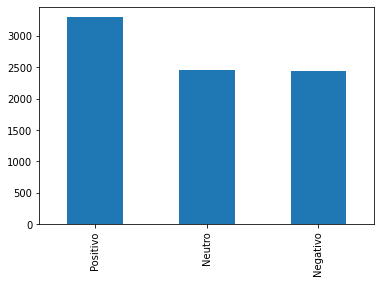

In [ ]:
%matplotlib inline 
df.Classificacao.value_counts().plot(kind='bar')

In [ ]:
df.Text.count()

8199

## Pre-Processamento dos Dados

* Remove linhas duplicadas na base de dados
* Problema na coleta dos dados.
* Remove Stopwords
* Stemming ou Lemmatization
* Remove caracteres indesejados como links etc.

In [ ]:
df.drop_duplicates(['Text'], inplace=True)
df.Text.count()

5765

## **Separando tweets e suas Classes**

In [ ]:
tweets = df['Text']
classes= df['Classificacao']

**Instalar bibliotecas e baixar a base de dados**

In [ ]:
#Bibliotecas da NLTK. kit de ferramentas para trabalhar com textos. 
import nltk
nltk.download( 'stopwords')
nltk.download( 'rslp')
nltk.download( 'punkt')
nltk.download( 'wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

**Funções de Pre-processamento de dados**

In [ ]:
def RemoveStopWords(instancia):
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [i for i in instancia.split() if not i in stopwords]
    return  (" ".join(palavras))

In [ ]:
def Stemming(instancia):
    stemmer = nltk.stem.RSLPStemmer()
    palavras = []
    for w in instancia.split():
        palavras.append(stemmer.stem(w))
    return (" ".join(palavras))

In [ ]:
def limpeza_dados(instancia):
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','')
    return (instancia)

In [ ]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def Lemmatization(instancia):
  palavras = []
  for w in instancia.split():
      palavras.append(wordnet_lemmatizer.lemmatize(w))
  return (" ".join(palavras))

**Entenda como funciona cada função**

In [ ]:
RemoveStopWords('Eu não gosto do partido, e também não votaria novamente nesse governante!')

'Eu gosto partido, votaria novamente nesse governante!'

In [ ]:
Stemming('Eu não gosto do partido, e também não votaria novamente nesse governante!')

'eu não gost do partido, e também não vot nov ness governante!'

In [ ]:
limpeza_dados('Assita aqui o video do Governador falando sobre a CEMIG https://www.uol.com.br :) ;)')

'assita aqui o video do governador falando sobre a cemig   '

In [ ]:
Lemmatization('Os carros são bonitos')

'Os carros são bonito'

**Aplica as 3 funções de Pre-processamento nos dados**

In [ ]:
def Preprocessing(instancia):
    stemmer = nltk.stem.RSLPStemmer()
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','')
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [stemmer.stem(i) for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

# Aplica a função em todos os dados:
tweets = [Preprocessing(i) for i in tweets]

**Visualize os dados e veja como ficou após o pré-processamento**

In [ ]:
tweets[:50]

0     ���⛪ @ Catedral de Santo Antônio - Governador ...
1     � @ Governador Valadares, Minas Gerais https:/...
2     �� @ Governador Valadares, Minas Gerais https:...
3                           ��� https://t.co/BnDsO34qK0
4     ��� PSOL vai questionar aumento de vereadores ...
5     " bom é bandido morto"\nDeputado Cabo Júlio é ...
6     "..E 25% dos mineiros dizem não torcer para ti...
7     "A gigantesca barba do mal" em destaque no cad...
8     "BB e governo de Minas travam disputa sobre de...
9     "com vcs bh fica pequena!" Belo Horizonte (pro...
10    "Daí a gente visita governador valadares"\n"Qu...
11    "É bonita e é bonita..." \n#latergram #ibituru...
12    "erro desconhecido" é mato! Aliás, é da secret...
13    "La La Land: Cantando Estações" arrasa no Glob...
14    "La La Land: Cantando Estações" arrasa no Glob...
15    "Los abusos, aun en el estado más sólido, son ...
16    "Mesmo sem muito dinheiro no caixa o governo d...
17    "Modelo de segurança será o nosso legado",

**Tokenização**
- Atente para o tipo de dados que você está trabalhando.

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
Frase = frase = 'A live do @blogminerando é show! :) :-) ;) =D'
tweet_tokenizer = TweetTokenizer()
tweet_tokenizer.tokenize(Frase)

['A',
 'live',
 'do',
 '@blogminerando',
 'é',
 'show',
 '!',
 ':)',
 ':-)',
 ';)',
 '=D']

CRIANDO O MODELO. 

**Instancia o objeto que faz a vetorização dos dados de texto**

In [ ]:
vectorizer = CountVectorizer(analyzer="word", tokenizer=tweet_tokenizer.tokenize)

**Aplica o vetorizador nos dados de texto**

In [ ]:
freq_tweets = vectorizer.fit_transform(tweets)
type(freq_tweets)

scipy.sparse.csr.csr_matrix

**Formato (Linhas, Colunas) da matriz**

In [ ]:
freq_tweets.shape

(5765, 13361)

Treino do modelo de Machine Learning

In [ ]:
modelo = MultinomialNB()
modelo.fit(freq_tweets, Classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Testando o modelo com algumas instâncias simples

In [ ]:
testes = ['Eu gosto de comidas apimentadas  ',
          'Estou muito feliz.',
          'O estado de Minas Gerais decretou calamidade financeira!!!',
          'Estou com medo de entrar neste lugar',
           'O dia de hoje vai ser ótimo']

In [ ]:
# Transforma os dados de teste em vetores de palavras.
freq_testes = vectorizer.transform(testes)

In [ ]:
for t, c in zip(testes,modelo.predict(freq_testes)):
    print (t+" ,"+c )

Eu gosto de comidas apimentadas   ,Neutro
Estou muito feliz. ,Neutro
O estado de Minas Gerais decretou calamidade financeira!!! ,Negativo
Estou com medo de entrar neste lugar ,Neutro
O dia de hoje vai ser ótimo ,Neutro


In [ ]:
print(modelo.classes_)
modelo.predict_proba(freq_testes).round(2)


['Negativo' 'Neutro' 'Positivo']


array([[0.12, 0.82, 0.05],
       [0.02, 0.97, 0.01],
       [0.99, 0.01, 0.  ],
       [0.01, 0.96, 0.03],
       [0.  , 0.99, 0.  ]])

## **Tags de Negações**

* Acrescenta uma tag _NEG encontrada após um 'não'.
* Objetivo é dar mais peso para o modelo identificar uma inversão de sentimento da frase.
* Exemplos: 
    - Eu gosto de cachorros, positivo.
    - Eu **não** gosto de cachorros, negativo.

In [ ]:
def marque_negacao(texto):
    negacoes = ['não','not']
    negacao_detectada = False
    resultado = []
    palavras = texto.split()
    for p in palavras:
        p = p.lower()
        if negacao_detectada == True:
            p = p + '_NEG'
        if p in negacoes:
            negacao_detectada = True
        resultado.append(p)
    return (" ".join(resultado))

## **Criando modelos com Pipelines**

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
pipeline_simples = Pipeline([
  ('counts', CountVectorizer()),
  ('classifier', MultinomialNB())
])

In [ ]:
pipeline_negacoes = Pipeline([
  ('counts', CountVectorizer(tokenizer=lambda text: marque_negacao(text))),
  ('classifier', MultinomialNB())
])

In [ ]:
pipeline_simples.fit(tweets,classes)


Pipeline(memory=None,
         steps=[('counts',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
pipeline_simples.steps

[('counts',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                  lowercase=True, max_df=1.0, max_features=None, min_df=1,
                  ngram_range=(1, 1), preprocessor=None, stop_words=None,
                  strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                  tokenizer=None, vocabulary=None)),
 ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

* Gera o modelo de negações

In [ ]:
pipeline_negacoes.fit(tweets,classes)

Pipeline(memory=None,
         steps=[('counts',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function <lambda> at 0x7f0d8226bd08>,
                                 vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

* Etapas do pipeline

In [ ]:
pipeline_negacoes.steps

[('counts',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                  lowercase=True, max_df=1.0, max_features=None, min_df=1,
                  ngram_range=(1, 1), preprocessor=None, stop_words=None,
                  strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                  tokenizer=<function <lambda> at 0x7f0d8226bd08>,
                  vocabulary=None)),
 ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

Modelo com SVM


In [ ]:
pipeline_svm_simples = Pipeline([
  ('counts', CountVectorizer()),
  ('classifier', svm.SVC(kernel='linear'))
])

In [ ]:
pipeline_svm_negacoes = Pipeline([
  ('counts', CountVectorizer(tokenizer=lambda text: marque_negacao(text))),
  ('classifier', svm.SVC(kernel='linear'))
])

## Validando os Modelos com Validação Cruzada

* Fazendo o cross validation do modelo

In [ ]:
resultados = cross_val_predict(pipeline_simples, tweets, classes, cv=10)

* Medindo a acurácia média do modelo

In [ ]:
metrics.accuracy_score(classes,resultados)

0.8716392020815265

* Medidas de validação do modelo

In [ ]:
sentimento=['Positivo','Negativo','Neutro']
print (metrics.classification_report(classes,resultados,sentimento))

              precision    recall  f1-score   support

    Positivo       0.95      0.89      0.92      2840
    Negativo       0.80      0.87      0.83       951
      Neutro       0.81      0.84      0.83      1974

    accuracy                           0.87      5765
   macro avg       0.85      0.87      0.86      5765
weighted avg       0.88      0.87      0.87      5765



* Matriz de confusão

In [ ]:
print (pd.crosstab(classes, resultados, rownames=['Real'], colnames=['Predito'], margins=True))

Predito   Negativo  Neutro  Positivo   All
Real                                      
Negativo       832     111         8   951
Neutro         175    1662       137  1974
Positivo        37     272      2531  2840
All           1044    2045      2676  5765


In [ ]:
def Metricas(modelo, tweets, classes):
  resultados = cross_val_predict(modelo, tweets, classes, cv=10)
  return 'Acurácia do modelo: {}'.format(metrics.accuracy_score(classes,resultados))

In [ ]:
# naive bayes simples
Metricas(pipeline_simples,tweets,classes)

'Acurácia do modelo: 0.8716392020815265'

In [ ]:
# naive bayes com tag de negacoes
Metricas(pipeline_negacoes,tweets,classes)

'Acurácia do modelo: 0.6830875975715525'

In [ ]:
# svm linear simples
Metricas(pipeline_svm_simples,tweets,classes)

'Acurácia do modelo: 0.8947094535993062'

In [ ]:
# svm linear com tag de negacoes
Metricas(pipeline_svm_negacoes,tweets,classes)

'Acurácia do modelo: 0.769297484822203'

## **Modelo com a Tag de Negações**

In [ ]:
resultados = cross_val_predict(pipeline_negacoes, tweets, classes, cv=10)

In [ ]:
metrics.accuracy_score(classes,resultados)

0.6830875975715525

In [ ]:
entimento=['Positivo','Negativo','Neutro']
print (metrics.classification_report(classes,resultados,sentimento))

              precision    recall  f1-score   support

    Positivo       0.69      0.89      0.78      2840
    Negativo       0.60      0.26      0.36       951
      Neutro       0.69      0.58      0.63      1974

    accuracy                           0.68      5765
   macro avg       0.66      0.58      0.59      5765
weighted avg       0.67      0.68      0.66      5765



* Matriz de confusão

In [ ]:
print (pd.crosstab(classes, resultados, rownames=['Real'], colnames=['Predito'], margins=True))

Predito   Negativo  Neutro  Positivo   All
Real                                      
Negativo       832     111         8   951
Neutro         175    1662       137  1974
Positivo        37     272      2531  2840
All           1044    2045      2676  5765


## **Considerações Finais**

Considere aumentar a quantidade de dados de treino.

Pela sua simplicidade o Naive Bayes pode ser usado perfeitamente como um algoritmo de Baseline.
